In [1]:
import pickle as pkl
import numpy as np
import pandas
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from sklearn.metrics import r2_score
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
# os.chdir("../../../Desktop/GDrive/opto_data")
os.chdir("C:/Users/julien/lab/data")

In [3]:
data = pkl.load(open("5sec_processed_optodata_withshort_3aug20.pkl", "rb"))
cdata = pkl.load(open("5sec_processed_control_optodata_withshort_4aug20.pkl", "rb"))

In [4]:
# Get only stim-site data
local_data = {}
for band in data.keys():
    local_data[band] = data[band][(data[band]["Is_stim_site_1"] == 1) & (data[band]["Is_stim_site_2"] == 1)]

In [5]:
first_data = {}
first_cdata = {}
first_local_data = {}

for band in data.keys():
    first_data[band] = data[band][data[band]["Block_num"] == 1]
    first_cdata[band] = cdata[band][cdata[band]["Block_num"] == 1]
    first_local_data[band] = local_data[band][local_data[band]["Block_num"] == 1]

## Look at feature distributions

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
first_data[band].columns

Index(['Initial_coh', 'Distance', 'Coh_proj', 'Coh_proj_sd', 'Phase',
       'From_electrodes', 'To_electrodes', 'Initial_coh_sd', 'Coh_diff_sd',
       'Coh_diff_avg', 'Pair_avg_net_coh', 'Pair_avg_net_coh_sd',
       'Graph_avg_net_coh', 'Graph_avg_net_coh_sd', 'Elec_cov', 'Time_cov',
       'Avg_coh_to_stim', 'Avg_stim_diff_btw_elec', 'End_diff', 'Delays',
       'Monkeys', 'Block_num', 'Experiment_block_key', 'Both_M1', 'Both_S1',
       'cond_diff_Y', 'cond_diff_percent_Y', 'diff_Y', 'diff_percent_Y',
       'Is_stim_site_1', 'Is_stim_site_2', 'Las1_distance_to_closer',
       'Las1_distance_to_further', 'Las2_distance_to_closer',
       'Las2_distance_to_further'],
      dtype='object')

In [8]:
# for band in first_data.keys():
#     d = first_data[band][['Initial_coh', 'Distance', 'Coh_proj', 'Coh_proj_sd', 'Phase',
#            'From_electrodes', 'To_electrodes', 'Initial_coh_sd', 'Coh_diff_sd',
#            'Coh_diff_avg', 'Pair_avg_net_coh', 'Pair_avg_net_coh_sd',
#            'Graph_avg_net_coh', 'Graph_avg_net_coh_sd', 'Elec_cov', 'Time_cov',
#            'Avg_coh_to_stim', 'Avg_diff_1-2_stim', 'Avg_stim_diff_btw_elec',
#            'End_diff', 'Delays',
#            'Las1_distance_to_closer', 'Las1_distance_to_further',
#            'Las2_distance_to_closer', 'Las2_distance_to_further']].values
#     scaler = StandardScaler()
#     d_scaled = pandas.DataFrame(scaler.fit_transform(d), columns = ['Initial_coh', 'Distance', 'Coh_proj', 'Coh_proj_sd', 'Phase',
#            'From_electrodes', 'To_electrodes', 'Initial_coh_sd', 'Coh_diff_sd',
#            'Coh_diff_avg', 'Pair_avg_net_coh', 'Pair_avg_net_coh_sd',
#            'Graph_avg_net_coh', 'Graph_avg_net_coh_sd', 'Elec_cov', 'Time_cov',
#            'Avg_coh_to_stim', 'Avg_diff_1-2_stim', 'Avg_stim_diff_btw_elec',
#            'End_diff', 'Delays',
#            'Las1_distance_to_closer', 'Las1_distance_to_further',
#            'Las2_distance_to_closer', 'Las2_distance_to_further'])

#     fig = plt.figure(figsize = (15, 15))
#     ax = fig.gca()
#     d_scaled.hist(ax=ax)
#     plt.show()

# Exploratory btw stim and control

In [9]:
all_data = pandas.DataFrame(columns = data["theta"].columns)
for band in data.keys():
    data[band]["stim"] = 1
    cdata[band]["stim"] = 0
    data[band]["band"] = band
    cdata[band]["band"] = band
    all_data = pandas.concat([all_data, data[band]], axis=0)
    all_data = pandas.concat([all_data, cdata[band]], axis=0)


In [10]:
all_data.head()

Initial_coh   Distance  Coh_proj  Coh_proj_sd     Phase From_electrodes  \
1     0.952858  10.049876  0.135458     3.448591  0.154126              12   
2     0.803837   8.062258  0.152518     3.747250  0.202207              12   
3     0.638091  10.198039  0.166312     4.218359  0.330463              12   
4     0.547514   8.246211  0.168097     4.341379  0.380658              12   
5     0.440340   4.472136  0.165656     4.358422  0.442892              12   

  To_electrodes  Initial_coh_sd  Coh_diff_sd  Coh_diff_avg  ...  \
1            14        0.004366     0.015148      0.087983  ...   
2            16        0.031769     0.020594      0.170465  ...   
3            18        0.056437     0.024936      0.248574  ...   
4            20        0.084296     0.038783      0.276688  ...   
5            22        0.097132     0.056346      0.295094  ...   

   diff_percent_Y  Is_stim_site_1  Is_stim_site_2  Las1_distance_to_closer  \
1       -0.011012               0               0                 7.211103   
2       -0.235263               0               0                 6.403124   
3        0.224765               0               0                 7.211103   
4        0.394948               0               0                 5.656854   
5        0.639944               0               0                 4.000000   

   Las1_distance_to_further  Las2_distance_to_closer  \
1                  7.810250                 8.062258   
2                  7.211103                 8.062258   
3                  7.211103                 7.071068   
4                  7.211103                 7.071068   
5                  7.211103                 8.602325   

   Las2_distance_to_further  stim   band  Coh_diff_mag  
1                 12.727922   1.0  theta           NaN  
2                 12.727922   1.0  theta           NaN  
3                 12.727922   1.0  theta           NaN  
4                 12.727922   1.0  theta           NaN  
5                 12.727922   1.0  theta           NaN  

[5 rows x 38 columns]

In [20]:
#comparison of deltas
for band in data.keys():
    print(band)
    print(stats.ttest_ind(cdata[band]["cond_diff_Y"], data[band]["cond_diff_Y"], equal_var=False))
    print(data[band]["cond_diff_Y"].mean() - cdata[band]["cond_diff_Y"].mean())

#     plt.figure(figsize=(10, 10))
#     sns.violinplot("band", "diff_Y", "stim", all_data, split=True, inner="quartile")
#     plt.title(band)
#     plt.show()
    
    print(stats.ttest_ind(cdata[band]["diff_Y"], data[band]["diff_Y"], equal_var=False))
    print(data[band]["diff_Y"].mean() - cdata[band]["diff_Y"].mean())

    print(stats.ttest_ind(first_cdata[band]["End_diff"], first_data[band]["End_diff"], equal_var=False))
    print(first_data[band]["End_diff"].mean() - first_cdata[band]["End_diff"].mean())
    
    # get average change per session
    print(stats.ttest_ind(list(data[band].groupby("Experiment_block_key")["diff_Y"].mean()), 
                          cdata[band].groupby("Experiment_block_key")["diff_Y"].mean(), equal_var=False))
    print(data[band].groupby("Experiment_block_key")["diff_Y"].mean().mean() -
                          cdata[band].groupby("Experiment_block_key")["diff_Y"].mean().mean())

    print()

theta
Ttest_indResult(statistic=-123.99184537166744, pvalue=0.0)
0.044272348159402945
Ttest_indResult(statistic=-29.31650350769751, pvalue=4.699817606165491e-188)
0.014719903233664889
Ttest_indResult(statistic=-47.405900982944466, pvalue=0.0)
0.07359951616832389
Ttest_indResult(statistic=1.3488669904340724, pvalue=0.24534749737165695)
0.012638909800243243

beta
Ttest_indResult(statistic=-62.316954887422085, pvalue=0.0)
0.01380120693894802
Ttest_indResult(statistic=-33.75406705289081, pvalue=2.4456421637407685e-248)
0.010011401656594775
Ttest_indResult(statistic=-40.25019119519451, pvalue=0.0)
0.05005700828297424
Ttest_indResult(statistic=1.6180123489573803, pvalue=0.17352645091066174)
0.009626069689612774

gamma
Ttest_indResult(statistic=-42.389246523824575, pvalue=0.0)
0.007219011569614543
Ttest_indResult(statistic=-47.54699552161662, pvalue=0.0)
0.010426279474013606
Ttest_indResult(statistic=-56.27462148341323, pvalue=0.0)
0.05213139737006672
Ttest_indResult(statistic=1.6286094668318

In [13]:
#comparison of raws
for band in data.keys():
    print(band)
    print(stats.ttest_ind(cdata[band]["Initial_coh"]+cdata[band]["cond_diff_Y"], data[band]["Initial_coh"]+data[band]["cond_diff_Y"], equal_var=False))
    print((data[band]["Initial_coh"]+data[band]["cond_diff_Y"]).mean() - (cdata[band]["Initial_coh"]+cdata[band]["cond_diff_Y"]).mean())

    print(stats.ttest_ind(cdata[band]["Initial_coh"]+cdata[band]["diff_Y"], data[band]["Initial_coh"]+data[band]["diff_Y"], equal_var=False))
    print((data[band]["Initial_coh"]+data[band]["diff_Y"]).mean() - (cdata[band]["Initial_coh"]+cdata[band]["diff_Y"]).mean())

    print(stats.ttest_ind(first_cdata[band]["Initial_coh"]+first_cdata[band]["End_diff"], first_data[band]["Initial_coh"]+first_data[band]["End_diff"], equal_var=False))
    print((first_data[band]["Initial_coh"]+first_data[band]["End_diff"]).mean() - (first_cdata[band]["Initial_coh"]+first_cdata[band]["End_diff"]).mean())

    print()

theta
Ttest_indResult(statistic=-148.73910246756674, pvalue=0.0)
0.13677594727465797
Ttest_indResult(statistic=-110.09071408053669, pvalue=0.0)
0.10722350234889821
Ttest_indResult(statistic=-68.93282825951188, pvalue=0.0)
0.14227465021398433

beta
Ttest_indResult(statistic=-90.97288727445404, pvalue=0.0)
0.10186550659305948
Ttest_indResult(statistic=-86.68087345795806, pvalue=0.0)
0.09807570131069482
Ttest_indResult(statistic=-47.1821718299421, pvalue=0.0)
0.11720218410359412

gamma
Ttest_indResult(statistic=-74.514289440749, pvalue=0.0)
0.07303961756093907
Ttest_indResult(statistic=-78.30757346899658, pvalue=0.0)
0.07624688546533331
Ttest_indResult(statistic=-46.35077600303777, pvalue=0.0)
0.09817374112919502

high_gamma
Ttest_indResult(statistic=-100.47541435174976, pvalue=0.0)
0.06757568938797859
Ttest_indResult(statistic=-78.75527544555491, pvalue=0.0)
0.052083204786166126
Ttest_indResult(statistic=-44.949691893042775, pvalue=0.0)
0.06786545929106302



# Stim-site only model

theta


<ipython-input-14-45ae510da1d6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_local_data[band]['abs_end_diff'] = np.abs(first_local_data[band]['End_diff'])


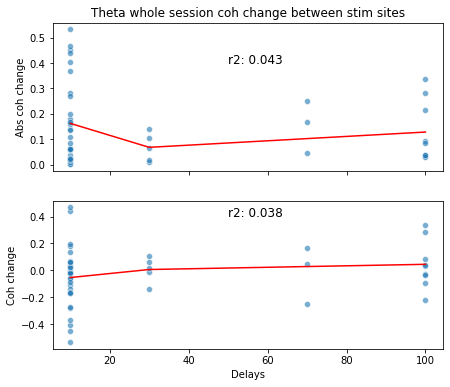

beta


<ipython-input-14-45ae510da1d6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_local_data[band]['abs_end_diff'] = np.abs(first_local_data[band]['End_diff'])


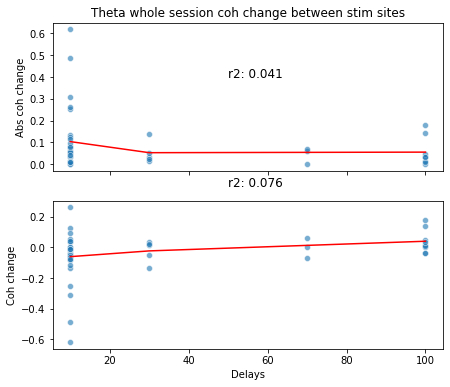

gamma


<ipython-input-14-45ae510da1d6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_local_data[band]['abs_end_diff'] = np.abs(first_local_data[band]['End_diff'])


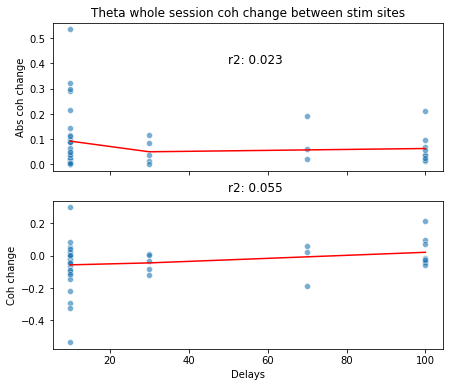

high_gamma


<ipython-input-14-45ae510da1d6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_local_data[band]['abs_end_diff'] = np.abs(first_local_data[band]['End_diff'])


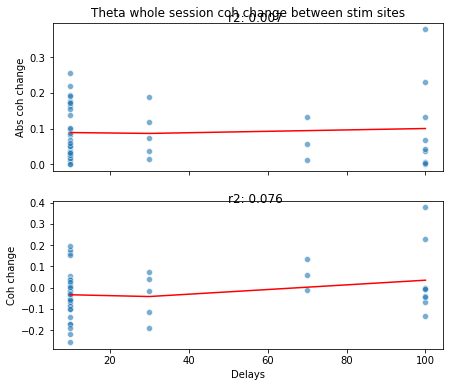

In [14]:
# Whole session changes with only delay, categorical

for band in data.keys():
    print(band)
    fig, axs = plt.subplots(2, 1, figsize=(7, 6), sharex=True)
    
    first_local_data[band]['abs_end_diff'] = np.abs(first_local_data[band]['End_diff'])
    formula_all_wholesess = "abs_end_diff ~ C(Delays)"
    
    mod1 = ols(formula=formula_all_wholesess, data=first_local_data[band])
    res1 = mod1.fit()
    
#     plt.figure(figsize=(10, 6))
    sns.scatterplot(x="Delays", y="abs_end_diff", data=first_local_data[band], ax=axs[0], alpha=.6)
    axs[0].plot([10, 30, 100], res1.predict(pandas.DataFrame({"Delays": [10, 30, 100]})), color="red")
    axs[0].set_ylabel("Abs coh change")
    axs[0].text(50, .4, "r2: "+str(res1.rsquared)[:5], fontsize=12)
#     plt.ylabel("Change in coherence over session")
#     plt.show()
    axs[0].set_title("Theta whole session coh change between stim sites")

    formula_all_wholesess = "End_diff ~ C(Delays)"
    
    mod2 = ols(formula=formula_all_wholesess, data=first_local_data[band])
    res2 = mod2.fit()
    
#     plt.figure(figsize=(10, 6))
    sns.scatterplot(x="Delays", y="End_diff", data=first_local_data[band], ax=axs[1], alpha=.6)
    axs[1].plot([10, 30, 100], res2.predict(pandas.DataFrame({"Delays": [10, 30, 100]})), color="red")
    axs[1].set_ylabel("Coh change")
    axs[1].text(50, .4, "r2: "+str(res2.rsquared)[:5], fontsize=12)

#     plt.savefig("figs/stdp_net_and_abs.pdf")
    plt.show()
#     print(res1.rsquared)
#     print(res1.mse_total)
#     print(res1.f_pvalue)


In [15]:
os.listdir(".")

['5sec_processed_control_optodata_withshort_4aug20.pkl',
 '5sec_processed_optodata_withshort_3aug20.pkl']

# Whole-network model
Replicate these analyses with nonlinear modeling

In [26]:
# All data, whole-session changes
# Only delay

for band in data.keys():
    print(band)
    formula_delay = "End_diff ~ Delays"
    mod1 = ols(formula=formula_delay, data=first_data[band])
    res1 = mod1.fit()
#     print(res1.rsquared)
#     print(res1.f_pvalue)
    
    
    formula_protocol_wholesess = "End_diff ~ Distance + Phase + Delays + Monkeys + Block_num + Both_M1 + Both_S1 + \
    Las1_distance_to_closer + Las1_distance_to_further + Las2_distance_to_closer + Las2_distance_to_further"
    mod2 = ols(formula=formula_protocol_wholesess, data=first_data[band])
    res2 = mod2.fit()
#     print(anova_lm(res1, res2))
    print(res2.summary())
#     print(res1.rsquared)
#     print(res1.mse_total)

    formula_all_wholesess = "End_diff ~ Distance + Phase + Delays + Monkeys + Block_num + Both_M1 + Both_S1 + \
    Las1_distance_to_closer + Las1_distance_to_further + Las2_distance_to_closer + Las2_distance_to_further + \
    Initial_coh + Pair_avg_net_coh  + Elec_cov + \
    Time_cov + Coh_proj + Graph_avg_net_coh + Coh_diff_avg"
    mod3 = ols(formula=formula_all_wholesess, data=first_data[band])
    res3 = mod3.fit()
#     print(res3.summary())
#     print(anova_lm(res2, res3))

    
    print()

theta
                            OLS Regression Results                            
Dep. Variable:               End_diff   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     1226.
Date:                Tue, 04 Aug 2020   Prob (F-statistic):               0.00
Time:                        17:30:30   Log-Likelihood:                 37950.
No. Observations:              144991   AIC:                        -7.588e+04
Df Residuals:                  144980   BIC:                        -7.577e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept         


high_gamma
                            OLS Regression Results                            
Dep. Variable:               End_diff   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     998.0
Date:                Tue, 04 Aug 2020   Prob (F-statistic):               0.00
Time:                        17:30:34   Log-Likelihood:                 97362.
No. Observations:              144991   AIC:                        -1.947e+05
Df Residuals:                  144980   BIC:                        -1.946e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept   

In [27]:
# All data, whole-session changes
# Only protocol

for band in data.keys():
    print(band)
    formula_all_wholesess = "End_diff ~ Distance + Phase + Delays + Monkeys + Block_num + Both_M1 + Both_S1 + \
    Las1_distance_to_closer + Las1_distance_to_further + Las2_distance_to_closer + Las2_distance_to_further"
    mod1 = ols(formula=formula_all_wholesess, data=first_data[band])
    res1 = mod1.fit()
    print(res1.rsquared)
    print(res1.mse_total)

theta
0.07799586610918163
0.037622673178543405
beta
0.032874849255051575
0.021576114731392496
gamma
0.0542804055856283
0.016465753125731324
high_gamma
0.06440442310414018
0.016337279446444038


In [31]:
# All data, whole-session changes
# All features

for band in data.keys():
    print(band)
    formula_all_wholesess = "End_diff ~ Distance + Phase + Delays + Monkeys + Block_num + Both_M1 + Both_S1 + \
    Las1_distance_to_closer + Las1_distance_to_further + Las2_distance_to_closer + Las2_distance_to_further + \
    Initial_coh + Pair_avg_net_coh  + Elec_cov + \
    Time_cov + Coh_proj + Coh_diff_avg"
    mod1 = ols(formula=formula_all_wholesess, data=first_data[band])
    res1 = mod1.fit()
    print(res1.rsquared)

theta
0.24055813722419006
beta
0.13366926836766546
gamma
0.17569964020672146
high_gamma
0.22898161963332808


In [32]:
# All data, whole-session changes
# Only graph

for band in data.keys():
    print(band)
    formula_all_wholesess = "End_diff ~ Initial_coh + Pair_avg_net_coh  + Elec_cov + \
    Time_cov + Coh_proj + Coh_diff_avg"
    mod1 = ols(formula=formula_all_wholesess, data=first_data[band])
    res1 = mod1.fit()
    print(res1.rsquared)

theta
0.12535393002452044
beta
0.08996560053461522
gamma
0.08922218897242384
high_gamma
0.12300503205607594


In [33]:
# All data, all single-block changes
# Only protocol

for band in data.keys():
    print(band)
    formula_all = "diff_Y ~ Distance + Phase + Delays + Monkeys + Block_num + Both_M1 + Both_S1 + \
    Las1_distance_to_closer + Las1_distance_to_further + Las2_distance_to_closer + Las2_distance_to_further"
    mod1 = ols(formula=formula_all, data=data[band])
    res1 = mod1.fit()
    print(res1.rsquared)
#     print(res1.f_pvalue)

theta
0.00920381505884682
beta
0.006284786937886699
gamma
0.0065028756689099465
high_gamma
0.010567059368593146


In [55]:
# All data, all single-block changes
# Only graph

for band in data.keys():
    print(band)
    formula_all = "diff_Y ~ Initial_coh + Pair_avg_net_coh  + Elec_cov + \
    Time_cov + Coh_proj + Coh_diff_avg"
    mod1 = ols(formula=formula_all, data=data[band])
    res1 = mod1.fit()
    print(res1.rsquared)
#     print(res1.f_pvalue)

theta
0.04925202577572729
beta
0.03608754508075018
gamma
0.059258851786720745
high_gamma
0.10132320496894454


In [37]:
# All data, all single-block changes
# All features

for band in data.keys():
    print(band)
    formula_all_wholesess = "diff_Y ~ Distance + Phase + Delays + Monkeys + Block_num + Both_M1 + Both_S1 + \
    Las1_distance_to_closer + Las1_distance_to_further + Las2_distance_to_closer + Las2_distance_to_further + \
    Initial_coh + Pair_avg_net_coh  + Elec_cov + \
    Time_cov + Coh_proj + Coh_diff_avg"
    mod1 = ols(formula=formula_all, data=data[band])
    res1 = mod1.fit()
    print(res1.rsquared)
#     print(res1.f_pvalue)

theta
0.04925202577572729
beta
0.03608754508075018
gamma
0.059258851786720745
high_gamma
0.10132320496894454


In [34]:
# All data, with block interaction
# All features

for band in data.keys():
    print(band)
    formula_all_blockinteract = "diff_Y ~ C(Block_num) * (Distance + Phase + Delays + Monkeys + Both_M1 + Both_S1 + \
    Las1_distance_to_closer + Las1_distance_to_further + Las2_distance_to_closer + Las2_distance_to_further + \
    Initial_coh + Pair_avg_net_coh  + Elec_cov + \
    Time_cov + Coh_proj + Coh_diff_avg)"
    mod1 = ols(formula=formula_all_blockinteract, data=data[band])
    res1 = mod1.fit()
    print(res1.rsquared)

theta
0.14355732061569448
beta
0.0841163287845017
gamma
0.14924925510217624
high_gamma
0.20842055053539799
